In [2]:
import pandas as pd
import numpy as np
# Load the Parquet file
df = pd.read_parquet("IR_v09_df_all_features.parquet")

# Reconstruct the original 2D matrices
df['Merged Adjacency Matrix'] = df.apply(
    lambda row: np.array(row['Merged Adjacency Matrix']).reshape(row['Matrix_Shape']),
    axis=1
)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs --host localhost --port=6007

Epoch [50/3000], Train Loss: 0.9138, Val Loss: 0.9617, LR: 0.000001
Epoch [100/3000], Train Loss: 0.8771, Val Loss: 0.9305, LR: 0.000001
Epoch [150/3000], Train Loss: 0.8485, Val Loss: 0.9174, LR: 0.000001
Epoch [200/3000], Train Loss: 0.8248, Val Loss: 0.9135, LR: 0.000001
Epoch [250/3000], Train Loss: 0.7965, Val Loss: 0.9132, LR: 0.000001
Epoch [300/3000], Train Loss: 0.7645, Val Loss: 0.9147, LR: 0.000001
Epoch [350/3000], Train Loss: 0.7301, Val Loss: 0.9150, LR: 0.000001
Epoch [400/3000], Train Loss: 0.6951, Val Loss: 0.9125, LR: 0.000001
Epoch [450/3000], Train Loss: 0.6622, Val Loss: 0.9063, LR: 0.000001
Epoch [500/3000], Train Loss: 0.6314, Val Loss: 0.9029, LR: 0.000001
Epoch [550/3000], Train Loss: 0.6076, Val Loss: 0.8992, LR: 0.000001
Epoch [600/3000], Train Loss: 0.5886, Val Loss: 0.8952, LR: 0.000001
Epoch [650/3000], Train Loss: 0.5727, Val Loss: 0.8914, LR: 0.000001
Epoch [700/3000], Train Loss: 0.5588, Val Loss: 0.8847, LR: 0.000001
Epoch [750/3000], Train Loss: 0.546

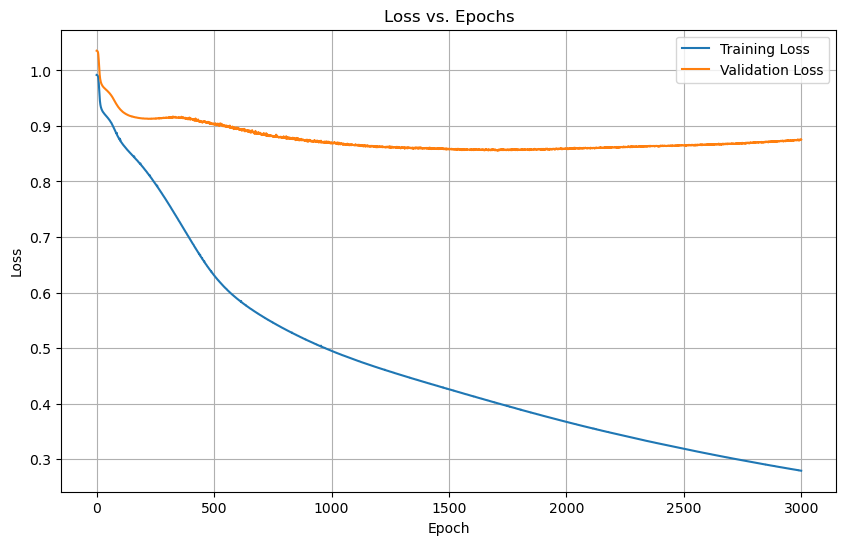

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

##############################################
# Prepare Data: Predict IR from Adjacency Matrix
##############################################

# Input: adjacency matrices (80x160) flattened
X = np.stack(df['Merged Adjacency Matrix'].values)  # Shape: (num_samples, 80, 160)

# Target: standardized log IR values
y_raw = np.log(np.vstack(df['y'].values) + 1)
scaler = StandardScaler()
y = scaler.fit_transform(y_raw)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 80, 160)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 80, 160)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##############################################
# Neural Network for Predicting IR Values
##############################################

class IRPredictorNN(nn.Module):
    def __init__(self, in_rows, in_cols, H1, H2, H3, D_out):
        super(IRPredictorNN, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(in_rows * in_cols, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.output = nn.Linear(H3, D_out)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        return self.output(x)

# Network dimensions
in_rows, in_cols = X_train_tensor.shape[1], X_train_tensor.shape[2]
D_out = y_train_tensor.shape[1]
H1, H2, H3 = 1024, 1024, 512
net = IRPredictorNN(in_rows, in_cols, H1, H2, H3, D_out)

##############################################
# Optimization and Loss Function for Regression
##############################################
learning_rate = 0.000001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.MSELoss()

# TensorBoard setup
logdir = f"{datetime.now().strftime('%Y-%m-%d')}_v9"
writer = SummaryWriter(log_dir="./logs/ir_pred/" + logdir)
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop
##############################################

num_epochs = 3000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = net(X_batch)
        loss = criterion(outputs, y_batch)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss / len(train_loader))

    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Logging
    writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
    writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    if (epoch + 1) % 50 == 0:
        save_path = f"./logs/ir_pred/{logdir}/model_epoch_{epoch + 1}.pt"
        torch.save(net.state_dict(), save_path)

        # Get wavelength values from dataframe
        wavelength = df['x'].iloc[0]  # assumes same x for all samples

        for i in range(3):
            pred = val_outputs[i].cpu().numpy()
            actual = y_test_tensor[i].cpu().numpy()

            # Scatter: predicted vs actual IR intensity
            #plt.figure()
            #plt.scatter(actual, pred, alpha=0.7)
            #plt.xlabel("Actual IR")
            #plt.ylabel("Predicted IR")
            #plt.title(f"IR Prediction Scatter - Example {i+1} (Epoch {epoch + 1})")
            #plt.grid(True)
            #writer.add_figure(f"IR_Prediction/Scatter_Example_{i+1}", plt.gcf(), global_step=epoch + 1)
            #plt.close()

            # Line plot: IR intensity vs wavelength
            plt.figure()
            plt.plot(wavelength, actual, label='Actual', linewidth=2)
            plt.plot(wavelength, pred, label='Predicted', linestyle='--', linewidth=2)
            plt.xlabel("Wavelength")
            plt.ylabel("IR Intensity")
            plt.title(f"IR Spectrum - Example {i+1} (Epoch {epoch + 1})")
            plt.legend()
            plt.grid(True)
            writer.add_figure(f"IR_Pred/Spectrum_Example_{i+1}", plt.gcf(), global_step=epoch + 1)
            plt.close()
            
        # Visualize weights of 3 example neurons per hidden layer
        with torch.no_grad():
            # Hidden Layer 1: input (80x160) => H1 neurons
            weights1 = net.hidden1.weight.view(H1, 80, 160).cpu().numpy()  # shape (256, 80, 160)
            for i in range(3):
                plt.figure()
                plt.imshow(weights1[i], cmap="viridis", aspect="auto")
                plt.colorbar()
                plt.title(f"Hidden1 - Neuron {i}")
                writer.add_figure(f"Weights/Hidden1_Neuron_{i}", plt.gcf(), global_step=epoch + 1)
                plt.close()

            # Hidden Layer 2: H1 => H2
            weights2 = net.hidden2.weight.cpu().numpy()  # shape (128, 256)
            for i in range(3):
                plt.figure()
                plt.imshow(weights2[i].reshape(32, 32), cmap="magma", aspect="auto")
                plt.colorbar()
                plt.title(f"Hidden2 - Neuron {i}")
                writer.add_figure(f"Weights/Hidden2_Neuron_{i}", plt.gcf(), global_step=epoch + 1)
                plt.close()

            # Hidden Layer 3: H2 => H3
            weights3 = net.hidden3.weight.cpu().numpy()  # shape (64, 128)
            for i in range(3):
                plt.figure()
                plt.imshow(weights3[i].reshape(32, 32), cmap="plasma", aspect="auto")
                plt.colorbar()
                plt.title(f"Hidden3 - Neuron {i}")
                writer.add_figure(f"Weights/Hidden3_Neuron_{i}", plt.gcf(), global_step=epoch + 1)
                plt.close()

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"LR: {current_lr:.6f}"
        )

##############################################
# Plot Training and Validation Losses
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Close TensorBoard writer
writer.close()

In [ ]:
#Let's try it with a CNN

Epoch [10/1000], Train Loss: 0.9395, Val Loss: 0.9721, LR: 0.000100
Epoch [20/1000], Train Loss: 0.9283, Val Loss: 0.9618, LR: 0.000100
Epoch [30/1000], Train Loss: 0.9165, Val Loss: 0.9485, LR: 0.000100
Epoch [40/1000], Train Loss: 0.9047, Val Loss: 0.9330, LR: 0.000100
Epoch [50/1000], Train Loss: 0.8927, Val Loss: 0.9181, LR: 0.000100
Epoch [60/1000], Train Loss: 0.8829, Val Loss: 0.9059, LR: 0.000100
Epoch [70/1000], Train Loss: 0.8708, Val Loss: 0.8951, LR: 0.000100
Epoch [80/1000], Train Loss: 0.8649, Val Loss: 0.8871, LR: 0.000100
Epoch [90/1000], Train Loss: 0.8592, Val Loss: 0.8774, LR: 0.000100
Epoch [100/1000], Train Loss: 0.8482, Val Loss: 0.8653, LR: 0.000100
Epoch [110/1000], Train Loss: 0.8381, Val Loss: 0.8613, LR: 0.000100
Epoch [120/1000], Train Loss: 0.8382, Val Loss: 0.8574, LR: 0.000100
Epoch [130/1000], Train Loss: 0.8310, Val Loss: 0.8562, LR: 0.000100
Epoch [140/1000], Train Loss: 0.8365, Val Loss: 0.8570, LR: 0.000100
Epoch [150/1000], Train Loss: 0.8201, Val L

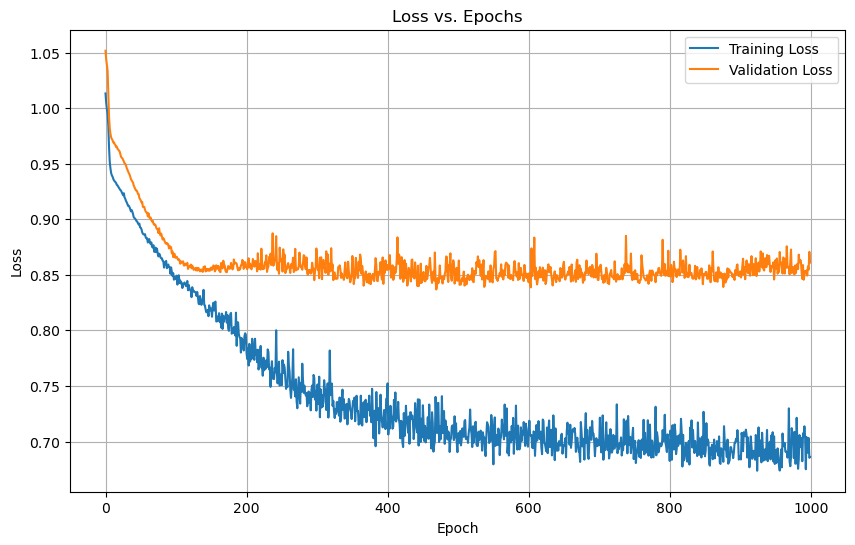

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

##############################################
# Prepare Data: Predict IR from Adjacency Matrix
##############################################

# Input: adjacency matrices (80x160) flattened
X = np.stack(df['Merged Adjacency Matrix'].values)  # Shape: (num_samples, 80, 160)

# Target: standardized log IR values
y_raw = np.log(np.vstack(df['y'].values) + 1)
scaler = StandardScaler()
y = scaler.fit_transform(y_raw)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, 80, 160)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)    # (N, 1, 80, 160)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##############################################
# Neural Network for Predicting IR Values
##############################################

class CNNPredictor(nn.Module):
    
    # this is our CNN initialization function     
    def __init__(self, num_output):
        # self is ... well ourself! (https://www.askpython.com/python/python-self-variable)
        # num_output is the number of wavelengths in the IR spectrum we want to predict

        # lets call our super function (https://www.pythonforbeginners.com/super/working-python-super-function)
        # we do this first, call its init fx
        super(CNNPredictor, self).__init__()

        # here is our "feature extraction" via convolutional layers 
        #   note: assume we got a single-channel 80x160 adjacency matrix per sample
        #         first layer
        #             80x160x1 -> convolution (1 stride, 1 padd, 3x3 kernel, 2 kernels) -> 80x160x2
        #         pooling
        #             pool of 4x4 => 80x160 / 4 => 20x40 now (technically, 20x40x2 right!)
        #         second layer
        #             20x40x2 -> convolution (1 stride, 1 padd, 3x3 kernel, 4 kernels) -> 20x40x4
        #         pooling
        #             pool of 4x4 => 20x40 / 4 => 5x10 now (technically, 5x10x4 right!)
        self.extract = nn.Sequential( 
            # lets make a 2D convolution layer
            nn.Conv2d(in_channels=1, out_channels=4, 
                      kernel_size=4, stride=1, padding=0), 
                         # in_channels = 1 for adjacency matrix
                         # out_channels = 2 means 2 shared weights/features
                         # kernel_size = 4 means a 4x4 size kernel
                         # stride = 1 means move one pixel at a time in each dim
                         # padding = adds one pixel of zeros to each side of each dim
                         #           note, thats what keeps our spatial dims the same for a 3x3 kernel
                         #           it also lets us process each location, even that border!!!
            nn.ReLU(inplace=True),
                         # could also use torch.nn.Sigmoid or etc.
                         # inplace means don't have to return a result, do it on the data
            # ----------------------------------------------------------- 
            # !!! hey, we just made a layer of convolution/nonlin !!!
            # ----------------------------------------------------------- 
            # lets pool using a 4x4 region that is not overlapping
            nn.MaxPool2d(kernel_size=2),                                                  
            # lets do dropout with a small percentage/rate               
            nn.Dropout(0.1),

            # ----------------------------------------------------------- 
            # now, lets make another layer of convolution, pooling, and drop out
            nn.Conv2d(in_channels=4, out_channels=8, 
                      kernel_size=3, stride=1, padding=1),
                         # in_channels here needs to match out_channels above
                         # lets use 4 filters 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1),
            
            # and another layer of convolution, pooling, and drop out
            nn.Conv2d(in_channels=8, out_channels=16, 
                      kernel_size=(3,39), stride=1, padding=(1,0)),
                         # in_channels here needs to match out_channels above
                         # lets use 4 filters 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1)),
            nn.Dropout(0.1)
        )

        # ok, now we are going to make a simple MLP regressor on the end of our above features
        # we compute flattened size dynamically based on 80x160 input
        dummy_input = torch.zeros(1, 1, 80, 160)
        flat_size = self.extract(dummy_input).view(1, -1).shape[1]

        self.decimate = nn.Sequential( 
            nn.Linear(flat_size, 12),  
                 # take our 4 filters whose response fields are 5x10 to 12 neurons
            nn.ReLU(inplace=True), 
                 # run a nonlinearity
            nn.Dropout(0.2), 
                 # some drop out
            nn.Linear(12, num_output) 
                 # map the 12 down to the number of IR wavelengths
        )

    #----------------------------
    # Model: Invoke Forward Pass
    #----------------------------
    def forward(self, x):
        features = self.extract(x)              # easy, pass input (x) to our "feature extraction" above
        features = features.view(features.size(0), -1)
        myresult = self.decimate(features)      # pass that to our MLP regressor, and done!!!
        return myresult

# Network dimensions
in_rows, in_cols = X_train_tensor.shape[1], X_train_tensor.shape[2]
D_out = y_train_tensor.shape[1]
H1, H2, H3 = 256, 128, 64

net = CNNPredictor(D_out)

##############################################
# Optimization and Loss Function for Regression
##############################################
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.MSELoss()

# TensorBoard setup
logdir = f"{datetime.now().strftime('%Y-%m-%d')}_CNN_v4"
writer = SummaryWriter(log_dir="./logs/ir_prediction/" + logdir)
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop
##############################################

num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.view(-1, 1, 80, 160)
        optimizer.zero_grad()
        outputs = net(X_batch)
        loss = criterion(outputs, y_batch)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss / len(train_loader))

    net.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.view(-1, 1, 80, 160)
        val_outputs = net(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Logging
    writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
    writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    if (epoch + 1) % 10 == 0:
        save_path = f"./logs/ir_prediction/{logdir}/model_epoch_{epoch + 1}.pt"
        torch.save(net.state_dict(), save_path)

        # Get wavelength values from dataframe
        wavelength = df['x'].iloc[0]  # assumes same x for all samples

        for i in range(3):
            pred = val_outputs[i].cpu().numpy()
            actual = y_test_tensor[i].cpu().numpy()

            # Scatter: predicted vs actual IR intensity
            #plt.figure()
            #plt.scatter(actual, pred, alpha=0.7)
            #plt.xlabel("Actual IR")
            #plt.ylabel("Predicted IR")
            #plt.title(f"IR Prediction Scatter - Example {i+1} (Epoch {epoch + 1})")
            #plt.grid(True)
            #writer.add_figure(f"IR_Prediction/Scatter_Example_{i+1}", plt.gcf(), global_step=epoch + 1)
            #plt.close()

            # Line plot: IR intensity vs wavelength
            plt.figure()
            plt.plot(wavelength, actual, label='Actual', linewidth=2)
            plt.plot(wavelength, pred, label='Predicted', linestyle='--', linewidth=2)
            plt.xlabel("Wavelength")
            plt.ylabel("IR Intensity")
            plt.title(f"IR Spectrum - Example {i+1} (Epoch {epoch + 1})")
            plt.legend()
            plt.grid(True)
            writer.add_figure(f"IR_Prediction/Spectrum_Example_{i+1}", plt.gcf(), global_step=epoch + 1)
            plt.close()

        # Visualize convolutional filters from each CNN layer
        with torch.no_grad():
            # First Conv2D Layer (in_channels=1, out_channels=4)
            conv1_weights = net.extract[0].weight.cpu().numpy()  # shape (4, 1, 4, 4)
            for i in range(min(3, conv1_weights.shape[0])):  # Up to 3 filters
                plt.figure()
                plt.imshow(conv1_weights[i, 0], cmap='viridis', aspect='auto')
                plt.title(f"Conv1 - Filter {i}")
                plt.colorbar()
                writer.add_figure(f"Weights/Conv1_Filter_{i}", plt.gcf(), global_step=epoch + 1)
                plt.close()
        
            # Second Conv2D Layer (in_channels=4, out_channels=8)
            conv2_weights = net.extract[4].weight.cpu().numpy()  # shape (8, 4, 3, 3)
            for i in range(min(3, conv2_weights.shape[0])):
                fig, axs = plt.subplots(1, 2, figsize=(6, 3))
                for j in range(2):  # only show 2 input channels for compactness
                    axs[j].imshow(conv2_weights[i, j], cmap='plasma', aspect='auto')
                    axs[j].set_title(f"InChan {j}")
                    axs[j].axis('off')
                fig.suptitle(f"Conv2 - Filter {i}")
                writer.add_figure(f"Weights/Conv2_Filter_{i}", fig, global_step=epoch + 1)
                plt.close()
        
            # Third Conv2D Layer (in_channels=8, out_channels=16)
            conv3_weights = net.extract[8].weight.cpu().numpy()  # shape (16, 8, 3, 39)
            for i in range(min(3, conv3_weights.shape[0])):
                fig, axs = plt.subplots(1, 1, figsize=(6, 3))
                axs.imshow(conv3_weights[i, 0], cmap='cividis', aspect='auto')  # input channel 0
                axs.set_title(f"Conv3 - Filter {i} (InChan 0)")
                axs.axis('off')
                writer.add_figure(f"Weights/Conv3_Filter_{i}", fig, global_step=epoch + 1)
                plt.close()

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"LR: {current_lr:.6f}"
        )

##############################################
# Plot Training and Validation Losses
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Close TensorBoard writer
writer.close()

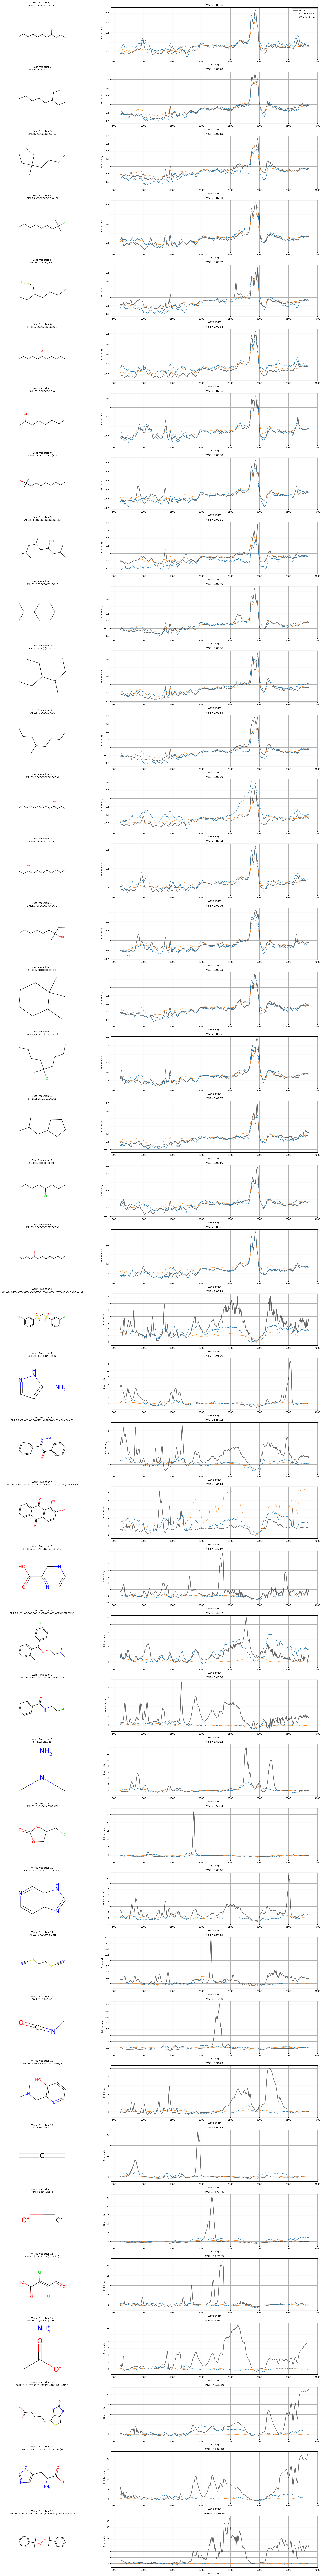

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define model paths and epochs
fc_model_path = "./logs/ir_pred/2025-04-16_v9/model_epoch_1700.pt"
cnn_model_path = "./logs/ir_prediction/2025-04-17_CNN_v4/model_epoch_450.pt"

# Load wavelength values (assumed same for all)
wavelength = df['x'].iloc[0]

##############################################
# Prepare Data and Preserve Original Indices
##############################################

# Reshape flattened (12800,) into (80, 160)
X = np.stack(df['Merged Adjacency Matrix'].values).reshape(-1, 80, 160)

# Target: log-scaled IR spectra
y_raw = np.log(np.vstack(df['y'].values) + 1)
scaler = StandardScaler()
y = scaler.fit_transform(y_raw)

# Split with index tracking
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42
)

# Convert to tensors
X_test_fc = torch.tensor(X_test, dtype=torch.float32).view(-1, 80, 160)       # for FC model
X_test_cnn = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)           # for CNN model (N, 1, 80, 160)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

##############################################
# Load Models
##############################################

fc_model = IRPredictorNN(80, 160, 1024, 1024, 512, y_test_tensor.shape[1])
fc_model.load_state_dict(torch.load(fc_model_path))
fc_model.eval()

cnn_model = CNNPredictor(y_test_tensor.shape[1])
cnn_model.load_state_dict(torch.load(cnn_model_path))
cnn_model.eval()

##############################################
# Make Predictions and Evaluate MSE
##############################################

with torch.no_grad():
    cnn_preds = cnn_model(X_test_cnn).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

mse = np.mean((cnn_preds - y_true) ** 2, axis=1)
best_indices = np.argsort(mse)[:20]
worst_indices = np.argsort(mse)[-20:]
selected_indices = list(best_indices) + list(worst_indices)

##############################################
# Plot Results with Molecule Structures
##############################################

plt.figure(figsize=(24, 160))  # Larger figure for 40 rows

for i, idx in enumerate(selected_indices):
    actual = y_true[idx]
    pred_fc = fc_model(X_test_fc[idx].unsqueeze(0)).detach().numpy().squeeze()
    pred_cnn = cnn_preds[idx]
    smiles = df.loc[test_idx[idx], 'smiles']
    mol = Chem.MolFromSmiles(smiles)
    mol_img = Draw.MolToImage(mol, size=(300, 300))

    # Plot molecule
    ax1 = plt.subplot(40, 2, 2 * i + 1)
    ax1.imshow(mol_img)
    ax1.axis('off')
    label = "Best" if i < 20 else "Worst"
    ax1.set_title(f"{label} Prediction {i % 20 + 1}\nSMILES: {smiles}", fontsize=10)

    # Plot IR predictions
    ax2 = plt.subplot(40, 2, 2 * i + 2)
    ax2.plot(wavelength, actual, label='Actual', color='black', linewidth=2, alpha=0.6)
    ax2.plot(wavelength, pred_fc, label='FC Prediction', linestyle='--', linewidth=1.5)
    ax2.plot(wavelength, pred_cnn, label='CNN Prediction', linestyle=':', linewidth=1.5)
    ax2.set_title(f"MSE={mse[idx]:.4f}")
    ax2.set_xlabel("Wavelength")
    ax2.set_ylabel("IR Intensity")
    ax2.grid(True)
    if i == 0:
        ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
